
## The First Trail was to hand the model 
## without feature extraction 


In [2]:
pip install pyradiomics

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 51.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 46.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp310-cp310-linux_x86_64.whl size=116961 sha256=14eab9ae7a07c8e08bf8ff3c09b687d34a055b56ab2e3e22ab9471ed0faa29e1
  Stored in directory: /root/.cache/pip/wheels/91/c

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import shutil as sh
import cv2 as cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization , Input
# Instead of 'from keras.preprocessing.image import ImageDataGenerator' use:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator from tensorflow.keras.preprocessing.image
from tensorflow.keras import regularizers
from keras.applications import ResNet50
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop,Adamax
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from skimage.feature import graycomatrix, graycoprops , hog 
from radiomics import featureextractor
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

extract paths from files

In [4]:
# Augmented Images
os.makedirs('/kaggle/working/data')

In [5]:
os.makedirs('/kaggle/working/data/Monkeypox')
os.makedirs('/kaggle/working/data/Others')


In [6]:
data_paths=[]
labels=[]

In [7]:
for i in os.listdir('/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images'):
    for ii in os.listdir('/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images'+'/'+i):
        data_paths.append('/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images'+'/'+i+'//'+ii)
        labels.append(i)

In [8]:
for i in os.listdir('/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1'):
    for ii in os.listdir(f'/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/{i}'):
        for iii in os.listdir(f'/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/{i}/{ii}'):
            data_paths.append(f'/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/{i}/{ii}/{iii}')
            labels.append(ii)

In [9]:
labels[-10:-1]

['Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others']

In [10]:
for i in os.listdir('/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images'):
    for ii in os.listdir(f'/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images/{i}'):
        data_paths.append(f'/kaggle/input/monkeypox-skin-lesion-dataset/Original Images/Original Images/{i}/{ii}')
        labels.append(i)

In [11]:
len(data_paths)

6027

In [12]:
df=pd.DataFrame({
    'paths': data_paths,
    'labels': labels
})

In [13]:
df.head()

paths            labels
0  /kaggle/input/monkeypox-skin-lesion-dataset/Au...  Others_augmented
1  /kaggle/input/monkeypox-skin-lesion-dataset/Au...  Others_augmented
2  /kaggle/input/monkeypox-skin-lesion-dataset/Au...  Others_augmented
3  /kaggle/input/monkeypox-skin-lesion-dataset/Au...  Others_augmented
4  /kaggle/input/monkeypox-skin-lesion-dataset/Au...  Others_augmented

In [14]:
df['labels']=df['labels'].replace('Monkeypox_augmented','Monkeypox')
df['labels']=df['labels'].replace('Others_augmented','Others')
df['labels']=df['labels'].replace('Monkey Pox','Monkeypox')

In [15]:
for i in range (len(df)):
    img=cv.imread(df.iloc[i,0])
    # print(img)
    img=cv.resize(img,(224,224))
    cv.imwrite(df.iloc[i,0],img)
    cv.imwrite(f'/kaggle/working/data/{df.iloc[i,1]}/{df.iloc[i,0].split("/")[-1]}',img)

In [16]:
df['labels'].unique()

array(['Others', 'Monkeypox'], dtype=object)

In [17]:
len(os.listdir('/kaggle/working/data/Others'))

1890

In [18]:
len(os.listdir('/kaggle/working/data/Monkeypox'))

1530

In [19]:
from collections import Counter

In [20]:
path=[]
label=[]
for i in os.listdir('/kaggle/working/'):
    for ii in os.listdir(f'/kaggle/working/{i}'):
        for iii in os.listdir(f'/kaggle/working/{i}/{ii}'):
            path.append(f'/kaggle/working/{i}/{ii}/{iii}')
            label.append(ii)

In [21]:
len(label)

3420

In [22]:
data=[]
for i in path:
    data.append(cv.imread(i))

In [23]:
data=np.array(data)


Text(0.5, 0, 'Class')

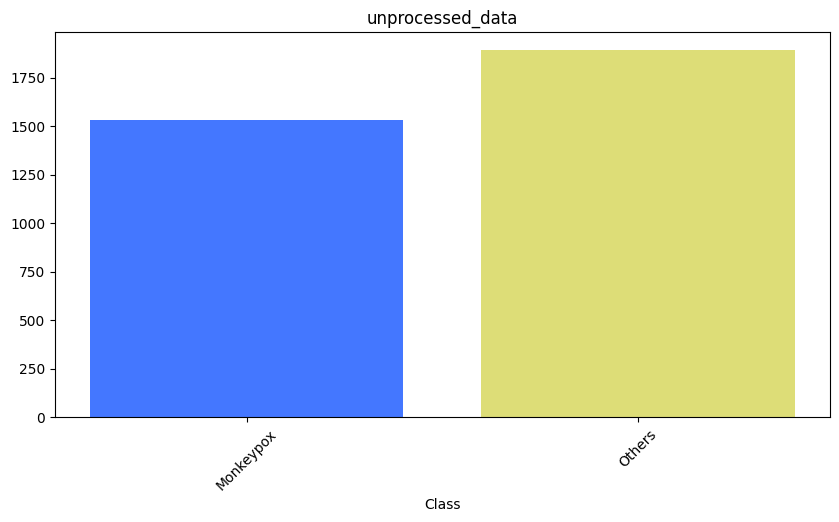

In [24]:
count=Counter(label)
plt.figure(figsize=(10,5))
plt.bar(count.keys(),count.values(),color=['#47f','#dd7'])
plt.xticks(rotation=45)
plt.title('unprocessed_data')
plt.xlabel('Class')

In [25]:
from imblearn.over_sampling import BorderlineSMOTE , ADASYN

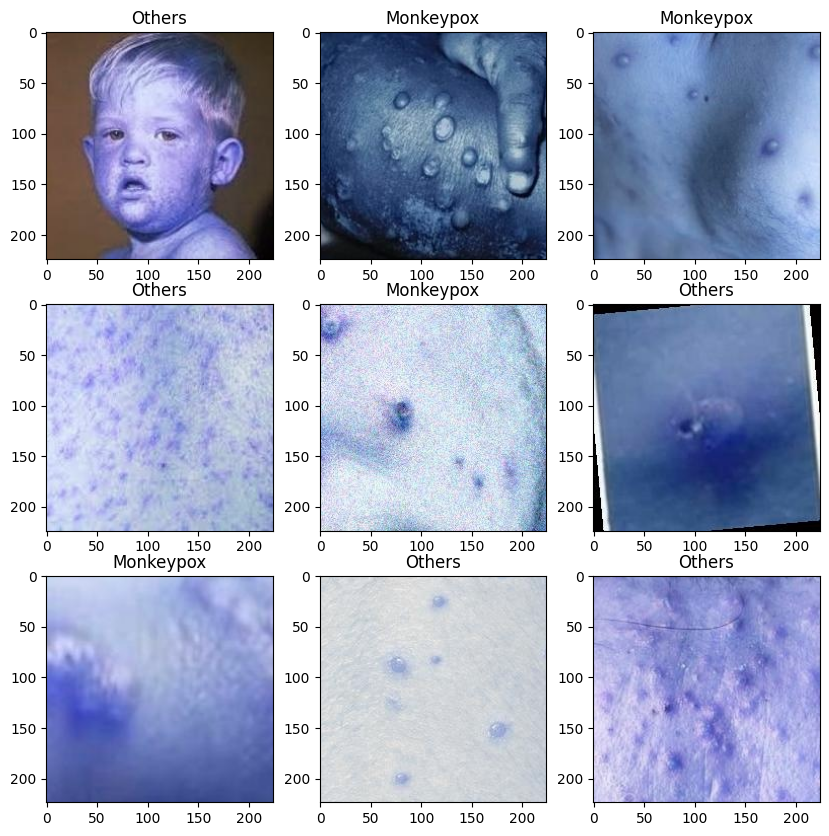

In [26]:
plt.figure(figsize=(10,10))
c=0
for i in (list(np.random.randint(1000,2500,9))):

    plt.subplot(3,3,c+1)
    img=cv.imread(path[i])
    plt.imshow(img)
    plt.title(f'{label[i]}')
    c+=1

In [27]:
BL=BorderlineSMOTE()
AS=ADASYN()

In [28]:
data_resampled , label_resampled = BL.fit_resample(data.reshape(-1,224*224*3),np.array(label))

In [29]:
proc_count=Counter(label_resampled)

In [30]:
data_resampled=data_resampled.reshape(-1,224,224,3)

Counter({'Monkeypox': 1890, 'Others': 1890})


Text(0.5, 0, 'Class')

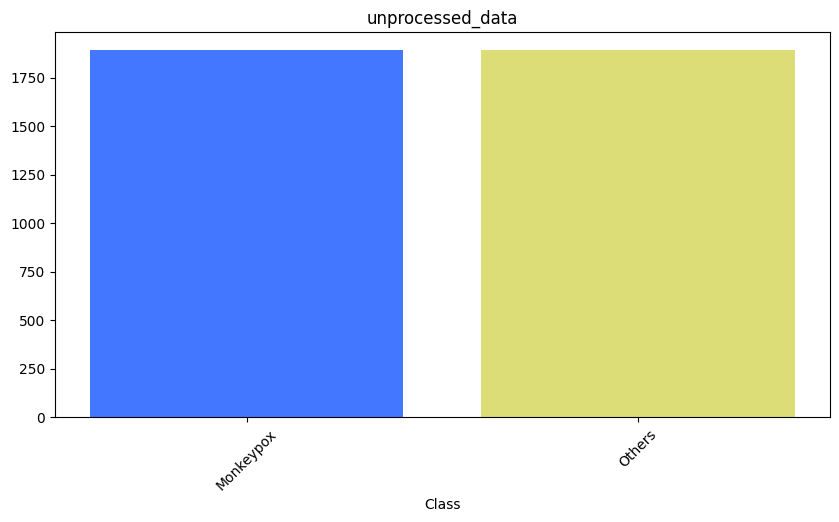

In [31]:
print(proc_count)
plt.figure(figsize=(10,5))
plt.bar(proc_count.keys(),proc_count.values(),color=['#47f','#dd7'])
plt.xticks(rotation=45)
plt.title('unprocessed_data')
plt.xlabel('Class')

Text(0.5, 1.0, 'Class Distribution')

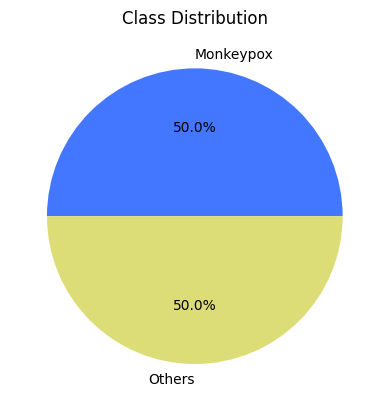

In [32]:
plt.pie(proc_count.values(),labels=proc_count.keys(),colors=['#47f','#dd7'],autopct='%1.1f%%')
plt.title('Class Distribution')

In [33]:
dat_re=data_resampled[range(len(data),len(data_resampled))]

In [34]:
label_re=label_resampled[range(len(label),len(label_resampled))]

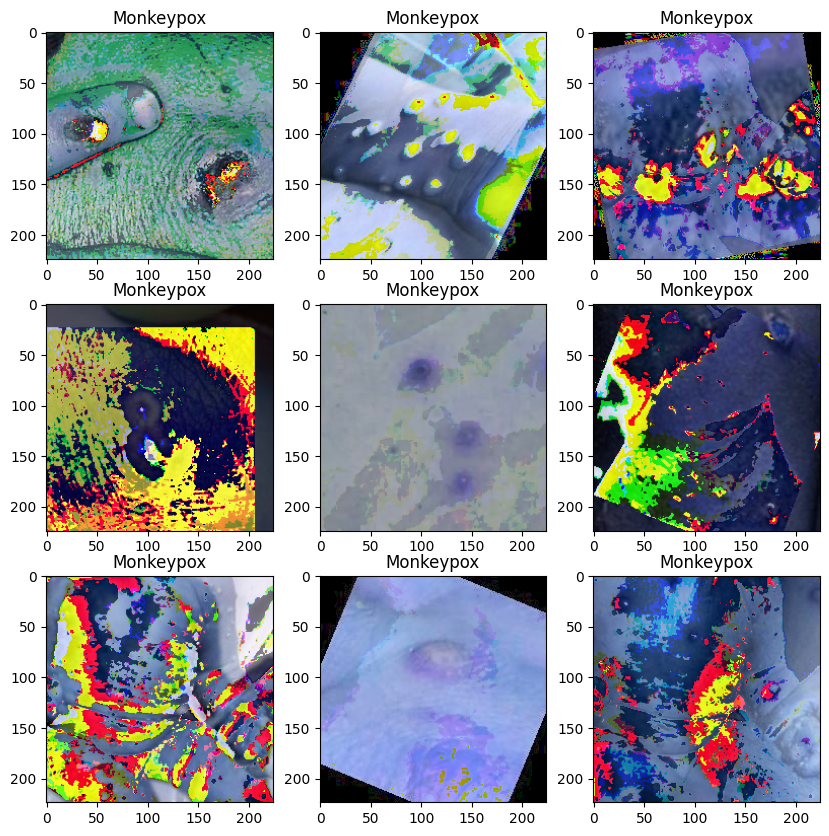

In [35]:
plt.figure(figsize=(10,10))
for i in range (9):
    plt.subplot(3,3,i+1)
    img=dat_re[i]
    plt.imshow(img)
    plt.title(f'{label_re[i]}')

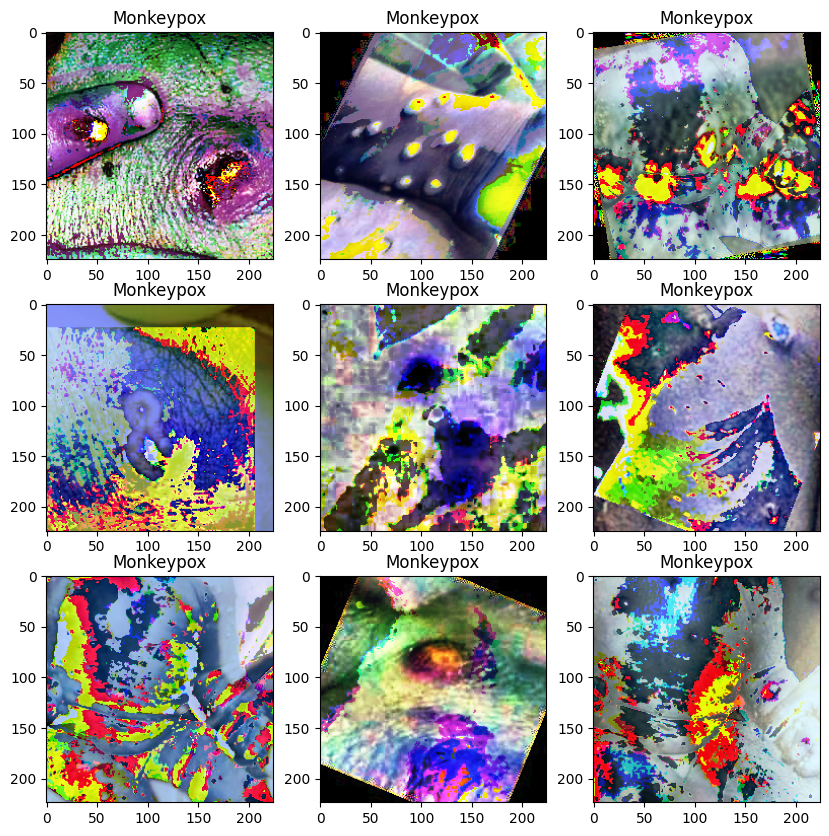

In [36]:
plt.figure(figsize=(10,10))
for i in range (9):
    plt.subplot(3,3,i+1)
    img=dat_re[i]
    r,g,b=cv.split(img)
    r=cv.equalizeHist(r)
    g=cv.equalizeHist(g)
    b=cv.equalizeHist(b)
    img=cv.merge((r,g,b))
    plt.imshow(img)
    plt.title(f'{label_re[i]}')

In [37]:
for i in range(len(dat_re)):
    img=dat_re[i]
    r,g,b=cv.split(img)
    r=cv.equalizeHist(r)
    g=cv.equalizeHist(g)
    b=cv.equalizeHist(b)
    img=cv.merge((r,g,b))
    cv.imwrite(f'/kaggle/working/data/{label_re[i]}/augmented_{np.random.randint(10000,50000)}.jpg',img)

In [38]:
len(os.listdir('/kaggle/working/data/Monkeypox'))

1890

In [39]:
len(os.listdir('/kaggle/working/data/Others'))

1890

In [40]:
final_paths=[]
final_labels=[]
for i in os.listdir('/kaggle/working/data'):
    for ii in os.listdir(f'/kaggle/working/data/{i}'):
        final_paths.append(f'/kaggle/working/data/{i}/{ii}')
        final_labels.append(i)

In [41]:
final_df=pd.DataFrame({'path':final_paths , 'label':final_labels })

In [42]:
final_df.head()

path      label
0       /kaggle/working/data/Monkeypox/M37_01_07.jpg  Monkeypox
1       /kaggle/working/data/Monkeypox/M25_02_11.jpg  Monkeypox
2  /kaggle/working/data/Monkeypox/augmented_49872...  Monkeypox
3  /kaggle/working/data/Monkeypox/augmented_28731...  Monkeypox
4  /kaggle/working/data/Monkeypox/augmented_39208...  Monkeypox

In [54]:
import cv2
# from skimage.feature import greycomatrix, greycoprops
import numpy as np

# Load image in grayscale
image_path = r"/kaggle/input/monkeypox-skin-lesion-dataset/Fold1/Fold1/Fold1/Test/Others/NM02_01.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Quantize the image (if needed)
image = (image / 16).astype(np.uint8)  # Reduce to 16 levels

# Compute GLCM
glcm = graycomatrix(image, distances=[1], angles=[0,45], levels=16, symmetric=True, normed=True)

# Extract GLCM features
contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
dissimilarity =graycoprops(glcm, 'dissimilarity')[0, 0]

# Print features
print(f"Contrast: {contrast}")
print(f"Correlation: {correlation}")
print(f"Energy: {energy}")
print(f"Homogeneity: {homogeneity}")
print(f"dissimilarity: {dissimilarity}")
print(glcm.shape)

Contrast: 0.27184096732863555
Correlation: 0.984073064953223
Energy: 0.30993117130902775
Homogeneity: 0.8734364446882583
dissimilarity: 0.2562259769378605
(16, 16, 1, 2)


In [55]:
def extract_features_with_grayCoMatrix(img_paths):
    angles=[0,45,90,135]
    features = []
    for img_path in img_paths:
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        img = (img / 16).astype(np.uint8)  # Reduce to 16 levels
        glcm = graycomatrix(img, distances=[1], angles=angles, levels=16, symmetric=True, normed=True)
        feature=[]
        for i in range(len(angles)):
            contrast = graycoprops(glcm, 'contrast')[0, i]
            feature.append(contrast)
            correlation = graycoprops(glcm, 'correlation')[0, i]
            feature.append(correlation)
            energy = graycoprops(glcm, 'energy')[0, i]
            feature.append(energy)
            homogeneity = graycoprops(glcm, 'homogeneity')[0, i]
            feature.append(homogeneity)
            dissimilarity =graycoprops(glcm, 'dissimilarity')[0, i]
            feature.append(dissimilarity)
        features.append(np.array(feature))
    return features

In [78]:
features = extract_features_with_grayCoMatrix(final_df['path'])
X = np.array(features)
labels={final_df['label'].unique()[0]:0 ,final_df['label'].unique()[1]:1  }
y = final_df['label'].map(labels)


In [79]:
labels

{'Monkeypox': 0, 'Others': 1}

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6402116402116402
              precision    recall  f1-score   support

           0       0.82      0.36      0.50       378
           1       0.59      0.92      0.72       378

    accuracy                           0.64       756
   macro avg       0.71      0.64      0.61       756
weighted avg       0.71      0.64      0.61       756



<Axes: >

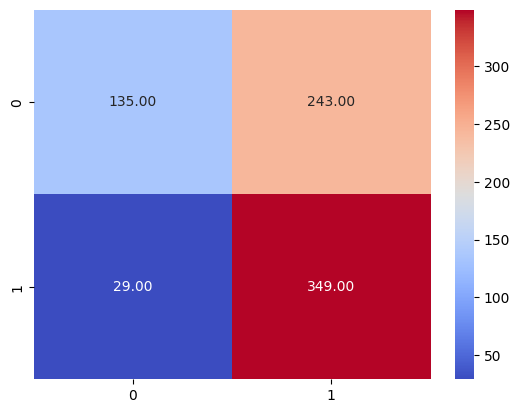

In [59]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [60]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8148148148148148
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       378
           1       0.79      0.85      0.82       378

    accuracy                           0.81       756
   macro avg       0.82      0.81      0.81       756
weighted avg       0.82      0.81      0.81       756



<Axes: >

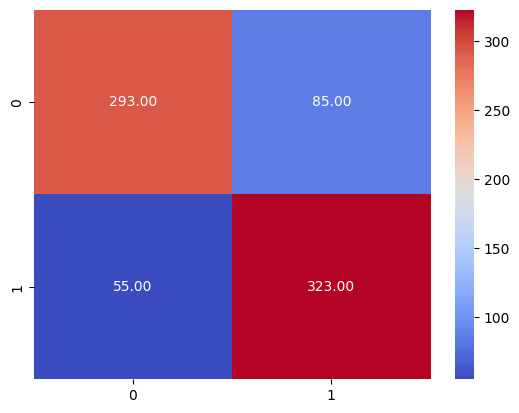

In [61]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [62]:
features = extract_features_with_grayCoMatrix(df.iloc[:,0])
X = np.array(features)
labels={final_df['label'].unique()[0]:0 ,final_df['label'].unique()[1]:1  }
y = df.iloc[:,1].map(labels)

re-oversampling with Borderline 

In [63]:
X_syn , y_syn=BL.fit_resample(X,y)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, test_size=0.2, random_state=42, stratify=y_syn)

In [65]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.5743243243243243
              precision    recall  f1-score   support

           0       0.61      0.41      0.49       666
           1       0.56      0.74      0.63       666

    accuracy                           0.57      1332
   macro avg       0.58      0.57      0.56      1332
weighted avg       0.58      0.57      0.56      1332



<Axes: >

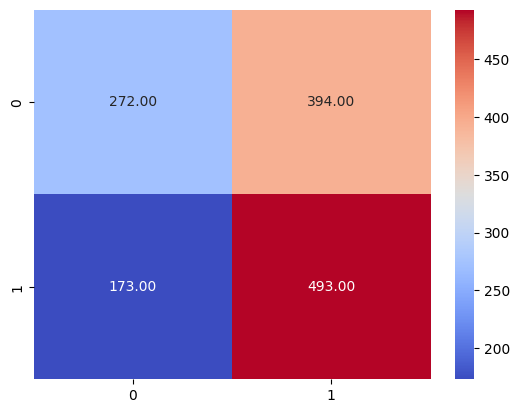

In [66]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [67]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8663663663663663
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       666
           1       0.87      0.86      0.87       666

    accuracy                           0.87      1332
   macro avg       0.87      0.87      0.87      1332
weighted avg       0.87      0.87      0.87      1332



<Axes: >

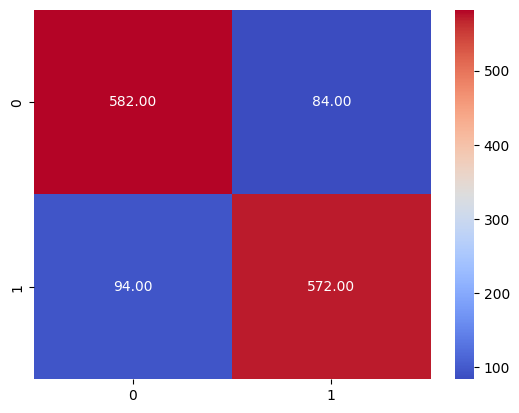

In [68]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

re-oversampling with ADASYN 

In [69]:
ADA=ADASYN()
X_syn , y_syn=ADA.fit_resample(X,y)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, test_size=0.2, random_state=42, stratify=y_syn)

In [71]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.552285050348567
              precision    recall  f1-score   support

           0       0.59      0.25      0.35       625
           1       0.54      0.83      0.66       666

    accuracy                           0.55      1291
   macro avg       0.57      0.54      0.51      1291
weighted avg       0.56      0.55      0.51      1291



<Axes: >

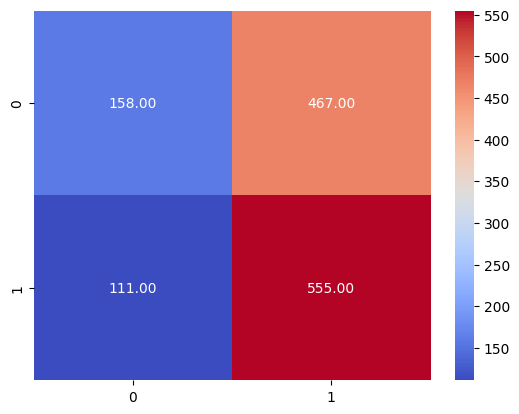

In [72]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [73]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8574748257164988
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       625
           1       0.87      0.85      0.86       666

    accuracy                           0.86      1291
   macro avg       0.86      0.86      0.86      1291
weighted avg       0.86      0.86      0.86      1291



<Axes: >

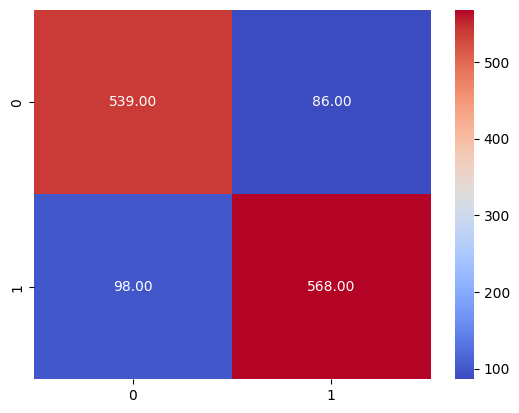

In [74]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [89]:
final_df['path']

0            /kaggle/working/data/Monkeypox/M37_01_07.jpg
1            /kaggle/working/data/Monkeypox/M25_02_11.jpg
2       /kaggle/working/data/Monkeypox/augmented_49872...
3       /kaggle/working/data/Monkeypox/augmented_28731...
4       /kaggle/working/data/Monkeypox/augmented_39208...
                              ...                        
3775           /kaggle/working/data/Others/NM23_01_10.jpg
3776           /kaggle/working/data/Others/NM58_02_08.jpg
3777           /kaggle/working/data/Others/NM32_01_08.jpg
3778           /kaggle/working/data/Others/NM21_01_01.jpg
3779           /kaggle/working/data/Others/NM08_01_01.jpg
Name: path, Length: 3780, dtype: object

In [98]:
def extract_features_with_hog(img_paths):
    features=[]
    for img_path in img_paths:
        img = cv.imread(f"{img_path}", cv.IMREAD_GRAYSCALE)
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        features.append(fd)
        print
    return features

In [99]:
labels

{'Monkeypox': 0, 'Others': 1}

In [100]:
features = extract_features_with_hog(final_df['path'])


In [101]:
X=np.array(features)
labels={final_df['label'].unique()[0]:0 ,final_df['label'].unique()[1]:1  }
y = final_df['label'].map(labels)


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [103]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8492063492063492
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       378
           1       0.82      0.89      0.86       378

    accuracy                           0.85       756
   macro avg       0.85      0.85      0.85       756
weighted avg       0.85      0.85      0.85       756



<Axes: >

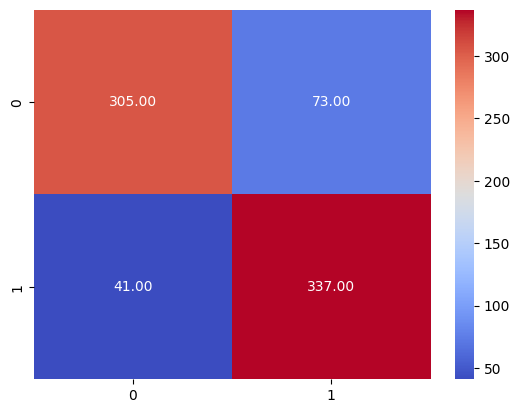

In [104]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [105]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.828042328042328
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       378
           1       0.85      0.80      0.82       378

    accuracy                           0.83       756
   macro avg       0.83      0.83      0.83       756
weighted avg       0.83      0.83      0.83       756



<Axes: >

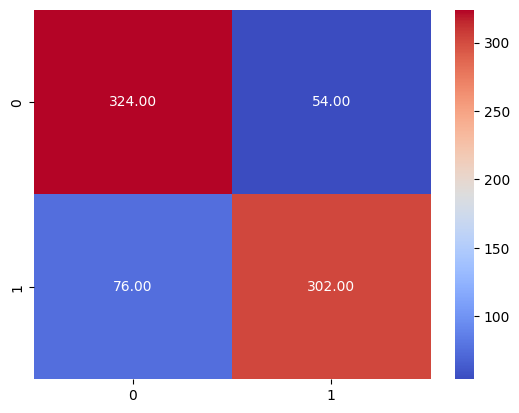

In [106]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [107]:
features = extract_features_with_hog(df.iloc[:,0])
X = np.array(features)
labels={final_df['label'].unique()[0]:0 ,final_df['label'].unique()[1]:1  }
y = df.iloc[:,1].map(labels)

re-oversampling with Borderline 

In [108]:
X_syn , y_syn=BL.fit_resample(X,y)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, test_size=0.2, random_state=42, stratify=y_syn)

In [110]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8933933933933934
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       666
           1       0.91      0.87      0.89       666

    accuracy                           0.89      1332
   macro avg       0.89      0.89      0.89      1332
weighted avg       0.89      0.89      0.89      1332



<Axes: >

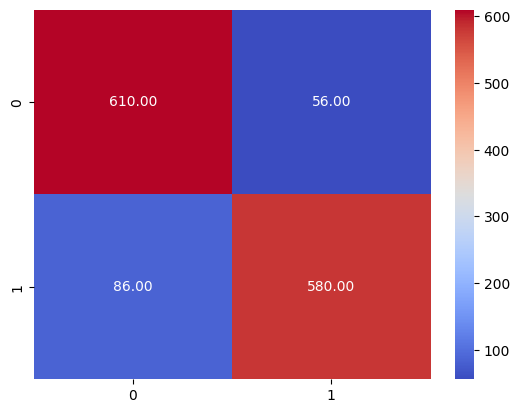

In [111]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [112]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8483483483483484
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       666
           1       0.89      0.80      0.84       666

    accuracy                           0.85      1332
   macro avg       0.85      0.85      0.85      1332
weighted avg       0.85      0.85      0.85      1332



<Axes: >

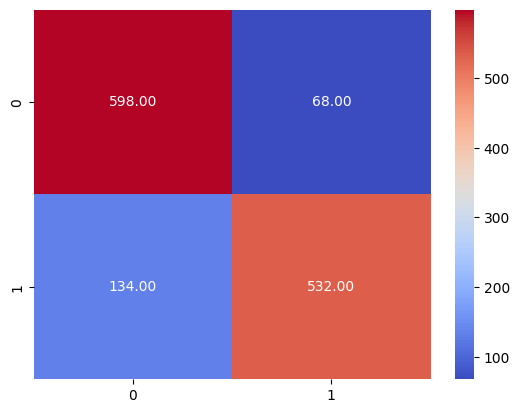

In [113]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

re-oversampling with ADASYN 

In [114]:
ADA=ADASYN()
X_syn , y_syn=ADA.fit_resample(X,y)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, test_size=0.2, random_state=42, stratify=y_syn)

In [116]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8829457364341086
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       624
           1       0.91      0.85      0.88       666

    accuracy                           0.88      1290
   macro avg       0.88      0.88      0.88      1290
weighted avg       0.88      0.88      0.88      1290



<Axes: >

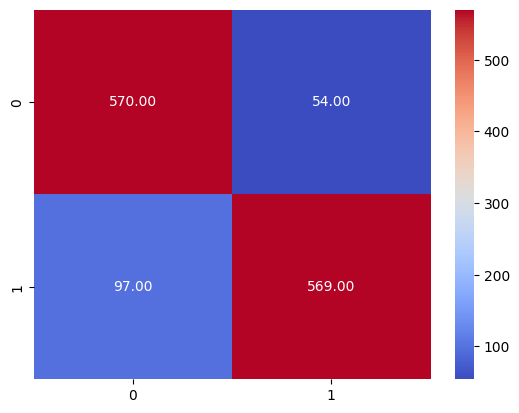

In [117]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [118]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8434108527131783
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       624
           1       0.86      0.83      0.85       666

    accuracy                           0.84      1290
   macro avg       0.84      0.84      0.84      1290
weighted avg       0.84      0.84      0.84      1290



<Axes: >

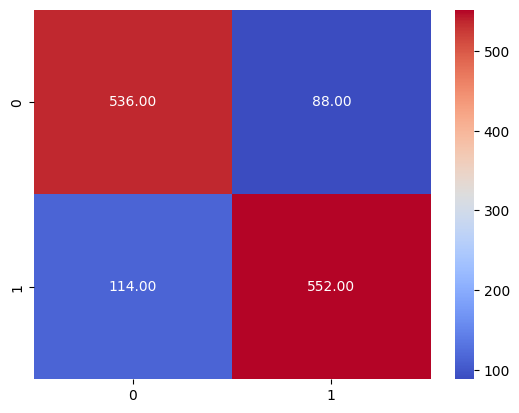

In [119]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [120]:
def extract_features_with_ResNet(img_paths):
    resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    features = []
    for img_path in img_paths:
        img = cv.imread(img_path)
        image = preprocess_input(np.expand_dims(img, axis=0))
    
    # Extract features
        feature = resnet_model.predict(image)
        features.append(feature.flatten())
    return features

In [121]:
labels

{'Monkeypox': 0, 'Others': 1}

In [ ]:
features = extract_features_with_ResNet(final_df['path'])
X = np.array(features)
labels={final_df['label'].unique()[0]:0 ,final_df['label'].unique()[1]:1  }
y = final_df['label'].map(labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [144]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9523809523809523
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       378
           1       0.94      0.97      0.95       378

    accuracy                           0.95       756
   macro avg       0.95      0.95      0.95       756
weighted avg       0.95      0.95      0.95       756



<Axes: >

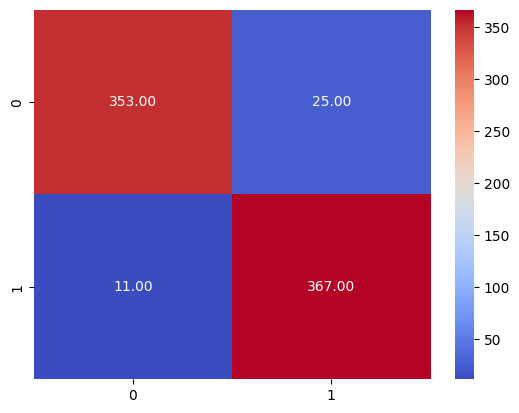

In [145]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [146]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       378
           1       0.90      0.94      0.92       378

    accuracy                           0.92       756
   macro avg       0.92      0.92      0.92       756
weighted avg       0.92      0.92      0.92       756



<Axes: >

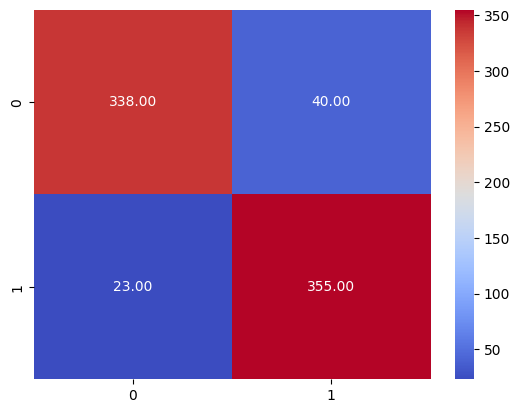

In [147]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [148]:
features = extract_features_with_ResNet(df.iloc[:,0])
X = np.array(features)
labels={final_df['label'].unique()[0]:0 ,final_df['label'].unique()[1]:1  }
y = df.iloc[:,1].map(labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

re-oversampling with Borderline 

In [171]:
X_syn , y_syn=BL.fit_resample(X,y)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, test_size=0.2, random_state=42, stratify=y_syn)

In [173]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9737237237237237
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       666
           1       0.97      0.97      0.97       666

    accuracy                           0.97      1332
   macro avg       0.97      0.97      0.97      1332
weighted avg       0.97      0.97      0.97      1332



<Axes: >

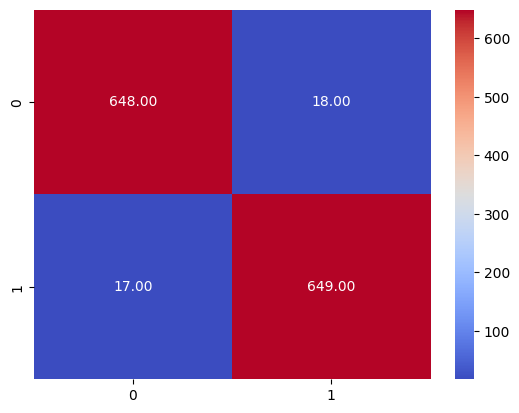

In [174]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [175]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9654654654654654
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       666
           1       0.98      0.95      0.97       666

    accuracy                           0.97      1332
   macro avg       0.97      0.97      0.97      1332
weighted avg       0.97      0.97      0.97      1332



<Axes: >

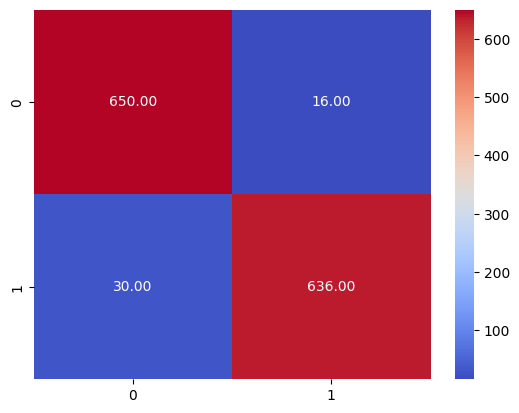

In [176]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

re-oversampling with ADASYN 

In [165]:
ADA=ADASYN()
X_syn , y_syn=ADA.fit_resample(X,y)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, test_size=0.2, random_state=42, stratify=y_syn)

In [167]:
clf = SVC(kernel='poly', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.977037037037037
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       684
           1       0.98      0.97      0.98       666

    accuracy                           0.98      1350
   macro avg       0.98      0.98      0.98      1350
weighted avg       0.98      0.98      0.98      1350



<Axes: >

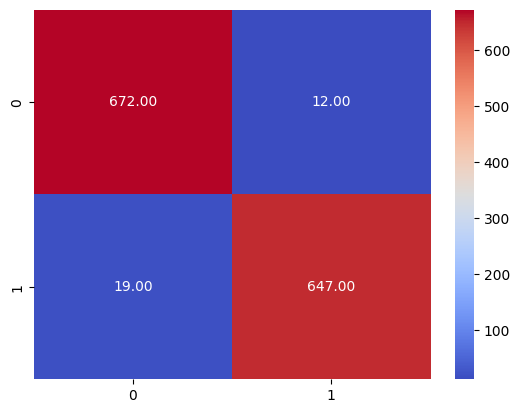

In [168]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")

In [169]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9644444444444444
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       684
           1       0.98      0.95      0.96       666

    accuracy                           0.96      1350
   macro avg       0.97      0.96      0.96      1350
weighted avg       0.96      0.96      0.96      1350



<Axes: >

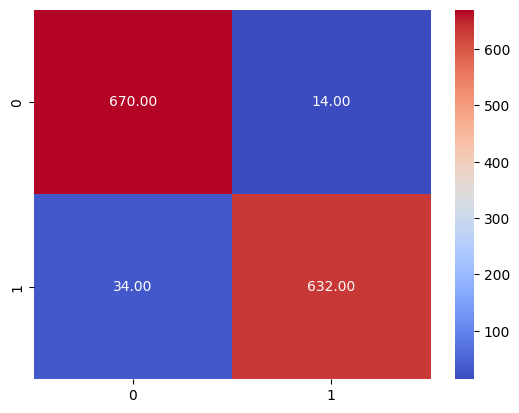

In [170]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm")